<a href="https://colab.research.google.com/github/lovepreetmultani/Anti-Money-Laundering/blob/main/xgboost_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports and Data load

In [1]:
!pip install explainerdashboard

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.2/287.2 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.6/220.6 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.5/136.5 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.0 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 2.3.7
    Uninstalling Werkzeug-2.3.7:
      Successfully uninstalled Werkzeug-2.3.7


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import time
from datetime import datetime as dt
from sklearn.feature_selection import  f_classif, SelectKBest
import matplotlib.pyplot as plt

In [3]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, f1_score

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
fraud=pd.read_csv("drive/My Drive/Dissertation/Dataset1-Big.csv")

In [6]:
fraud.head()

,tx_fraud,tx_amount,s_pagerank,s_label,s_min_send_tx,s_min_receieve_tx,s_max_send_tx,s_max_recieve_tx,s_avg_send_tx,s_avg_recieve_tx,...,r_label,r_min_send_tx,r_min_receieve_tx,r_max_send_tx,r_max_recieve_tx,r_avg_send_tx,r_avg_recieve_tx,r_cnt_recieve_tx,r_cnt_send_tx,r_timestamp
0,False,447.72,0.58295,36700160,447.72,179.57,447.72,292119.18,447.72000,1853.61565,...,36700160,447.72,179.57,447.72,292119.18,447.72000,1853.61565,200,178,199
1,False,447.72,6.36310,36700160,15.48,5.90,296.07,5246430.50,281.01446,34892.03171,...,36700160,15.48,5.90,296.07,5246430.50,281.01446,34892.03171,945,74,199
2,False,17.37,0.37284,36700160,17.37,21.94,17.37,2099443.75,17.37000,20834.57295,...,36700160,17.37,21.94,17.37,2099443.75,17.37000,20834.57295,105,220,199
3,False,17.37,0.32571,36700160,280.45,8.12,280.45,17.37,280.45000,12.09138,...,36700160,280.45,8.12,280.45,17.37,280.45000,12.09138,58,9,199
4,False,473.85,0.28323,36700160,473.85,134.02,473.85,2530242.00,473.85000,250599.53815,...,36700160,473.85,134.02,473.85,2530242.00,473.85000,250599.53815,27,177,199


In [7]:
fraud.columns

Index(['tx_fraud', 'tx_amount', 's_pagerank', 's_label', 's_min_send_tx',
       's_min_receieve_tx', 's_max_send_tx', 's_max_recieve_tx',
       's_avg_send_tx', 's_avg_recieve_tx', 's_cnt_recieve_tx',
       's_cnt_send_tx', 's_timestamp', 'r_pagerank', 'r_label',
       'r_min_send_tx', 'r_min_receieve_tx', 'r_max_send_tx',
       'r_max_recieve_tx', 'r_avg_send_tx', 'r_avg_recieve_tx',
       'r_cnt_recieve_tx', 'r_cnt_send_tx', 'r_timestamp'],
      dtype='object')

## Data balacing

In [8]:
from imblearn.over_sampling import SMOTE

# ... Your existing imports and code for reading data ...

# Features and labels before SMOTE
features = fraud[['tx_amount', 's_pagerank', 's_label', 's_min_send_tx',
                 's_min_receieve_tx', 's_max_send_tx', 's_max_recieve_tx',
                 's_avg_send_tx', 's_avg_recieve_tx', 's_cnt_recieve_tx',
                 's_cnt_send_tx', 's_timestamp', 'r_pagerank', 'r_label',
                 'r_min_send_tx', 'r_min_receieve_tx', 'r_max_send_tx',
                 'r_max_recieve_tx', 'r_avg_send_tx', 'r_avg_recieve_tx',
                 'r_cnt_recieve_tx', 'r_cnt_send_tx', 'r_timestamp']]
labels = fraud['tx_fraud']

# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
features_resampled, labels_resampled = smote.fit_resample(features, labels)

# Replace your original 'fraud' DataFrame with the resampled data
fraud_resampled = features_resampled.copy()
fraud_resampled['tx_fraud'] = labels_resampled

In [9]:
fraud_resampled['tx_fraud'].value_counts()

False    234716
True     234716
Name: tx_fraud, dtype: int64

## Data preprocessing

In [10]:
!pip install torch torchvision
!pip install torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 5.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=85295a642cc6b8d5b2435547a8619ee5a1ea5ec3580fced15e7263a3ca1da8f0
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch-geometric


In [11]:
import torch
from torch_geometric.data import Data


# Step 1: Map unique accounts to unique integer IDs
unique_accounts = pd.concat([fraud_resampled['s_label'], fraud_resampled['r_label']]).drop_duplicates()
account_to_id = {account: i for i, account in enumerate(unique_accounts)}

# Step 2: Create the edge_index tensor
source_node_indices = fraud_resampled['s_label'].map(account_to_id).values
target_node_indices = fraud_resampled['r_label'].map(account_to_id).values

edge_index = torch.tensor(
    [
        source_node_indices,  # Source nodes
        target_node_indices   # Target nodes
    ],
    dtype=torch.long
)

<ipython-input-11-170449250967>:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  edge_index = torch.tensor(


In [12]:
from sklearn.preprocessing import StandardScaler

# Extract the features from the resampled data
features_to_scale = ['tx_amount', 's_pagerank', 's_label', 's_min_send_tx',
                     's_min_receieve_tx', 's_max_send_tx', 's_max_recieve_tx',
                     's_avg_send_tx', 's_avg_recieve_tx', 's_cnt_recieve_tx',
                     's_cnt_send_tx', 's_timestamp', 'r_pagerank', 'r_label',
                     'r_min_send_tx', 'r_min_receieve_tx', 'r_max_send_tx',
                     'r_max_recieve_tx', 'r_avg_send_tx', 'r_avg_recieve_tx',
                     'r_cnt_recieve_tx', 'r_cnt_send_tx', 'r_timestamp']

# Initialize the scaler
scaler = StandardScaler()

# Apply scaling to the features
fraud_data_scaled = fraud_resampled.copy()
fraud_data_scaled[features_to_scale] = scaler.fit_transform(fraud_resampled[features_to_scale])


# Use the scaled features in the resampled dataset
fraud_resampled_scaled = fraud_data_scaled.copy()

# Node features for the sender and receiver
sender_features_scaled = torch.tensor(fraud_resampled_scaled[['s_pagerank', 's_label', 's_min_send_tx',
                                  's_min_receieve_tx', 's_max_send_tx', 's_max_recieve_tx',
                                  's_avg_send_tx', 's_avg_recieve_tx', 's_cnt_recieve_tx',
                                  's_cnt_send_tx', 's_timestamp']].values, dtype=torch.float)

receiver_features_scaled = torch.tensor(fraud_resampled_scaled[['r_pagerank', 'r_label', 'r_min_send_tx',
                                    'r_min_receieve_tx', 'r_max_send_tx', 'r_max_recieve_tx',
                                    'r_avg_send_tx', 'r_avg_recieve_tx', 'r_cnt_recieve_tx',
                                    'r_cnt_send_tx', 'r_timestamp']].values, dtype=torch.float)

# Combining the sender and receiver features
x_scaled = torch.cat([sender_features_scaled, receiver_features_scaled], dim=1)

# Edge features
edge_attr_scaled = torch.tensor(fraud_resampled_scaled[['tx_amount']].values, dtype=torch.float)

# Create a PyTorch Geometric data object with scaled features
data_scaled = Data(x=x_scaled, edge_index=edge_index, edge_attr=edge_attr_scaled)


## XGBoost

In [13]:
!pip install xgboost
import xgboost as xgb


Test train split

In [14]:
from sklearn.model_selection import train_test_split

# Initial train-test split
train_fraud, temp_fraud = train_test_split(fraud_resampled_scaled, test_size=0.4, random_state=42, stratify=fraud_resampled_scaled['tx_fraud'])

# Split the remaining 40% into validation and test sets
val_fraud, test_fraud = train_test_split(temp_fraud, test_size=0.5, random_state=42, stratify=temp_fraud['tx_fraud'])

In [15]:
X_train = fraud_resampled_scaled.loc[train_fraud.index, features_to_scale]
y_train = fraud_resampled_scaled.loc[train_fraud.index, 'tx_fraud']

X_val = fraud_resampled_scaled.loc[val_fraud.index, features_to_scale]
y_val = fraud_resampled_scaled.loc[val_fraud.index, 'tx_fraud']

X_test = fraud_resampled_scaled.loc[test_fraud.index, features_to_scale]
y_test = fraud_resampled_scaled.loc[test_fraud.index, 'tx_fraud']




Train

In [20]:
from xgboost import XGBRFClassifier
# Training the XGBoost model
''' xgb_model = XGBRFClassifier(
    nthread=-1, n_estimators=100, learning_rate=0.1,
    objective='binary:logistic', max_depth=2, scale_pos_weight=400,
    min_child_weight=80, gamma=10, max_delta_step=2
) '''
xgb_model = XGBRFClassifier(
   n_estimators=10
)
xgb_model.fit(X_train, y_train, eval_metric='error', eval_set=[(X_train, y_train), (X_val, y_val)])

# Making predictions on the test set using XGBoost
xgb_test_predictions = xgb_model.predict(X_test)

# Evaluate the XGBoost model using Precision on the test set
xgb_test_precision = precision_score(y_test, xgb_test_predictions)
print(f"XGBoost Test Precision: {xgb_test_precision}")

# Making predictions on the validation set using XGBoost
xgb_val_predictions = xgb_model.predict(X_val)

# Evaluate the XGBoost model using Precision on validation set
xgb_val_precision = precision_score(y_val, xgb_val_predictions)
print(f"XGBoost Validation Precision: {xgb_val_precision}")

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[0]	validation_0-error:0.02127	validation_1-error:0.02080
XGBoost Test Precision: 0.9685098406747892
XGBoost Validation Precision: 0.9689193696322855


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, f1_score
result = confusion_matrix(y_test, xgb_test_predictions)
print("Confusion Matrix:")
print(result)
print('\n')
result1 = classification_report(y_test, xgb_test_predictions)
print("Classification Report:",)
print (result1)
print('\n')
result2 = accuracy_score(y_test,xgb_test_predictions)
print("Accuracy:",result2)
print('\n')
# calculate precision and recall scores
precision = precision_score(y_test, xgb_test_predictions)
recall = recall_score(y_test, xgb_test_predictions)
f1score = f1_score(y_test, xgb_test_predictions)

# print the results
print("Precision:", precision)
print("Recall:", recall)
print("f1 score:", recall)

print(roc_auc_score(y_test, xgb_test_predictions))

fpr, tpr, _ = roc_curve(y_test, xgb_test_predictions)

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

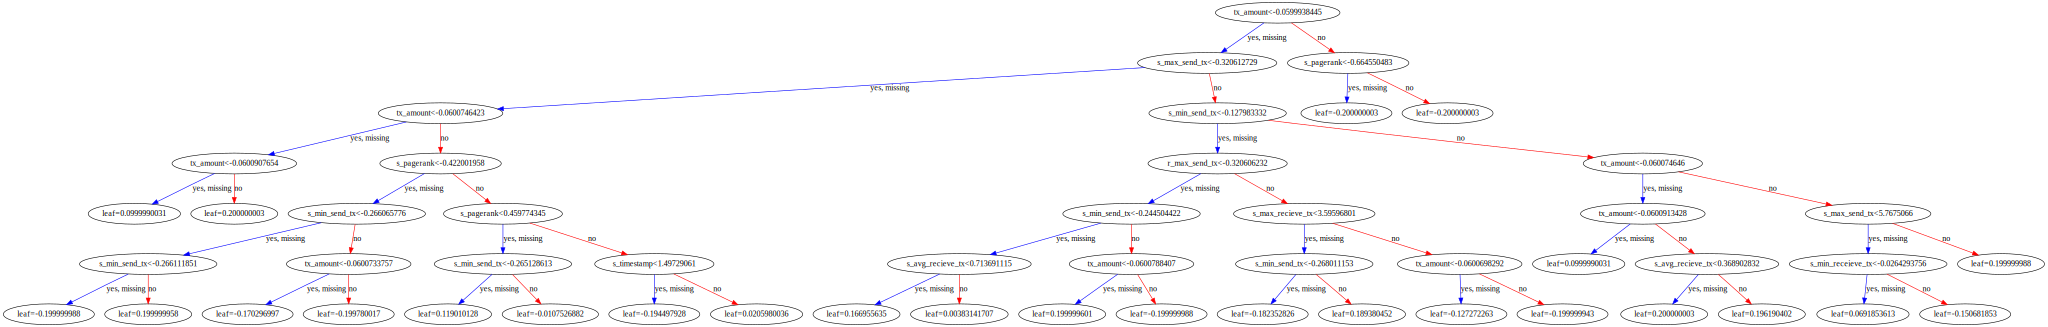

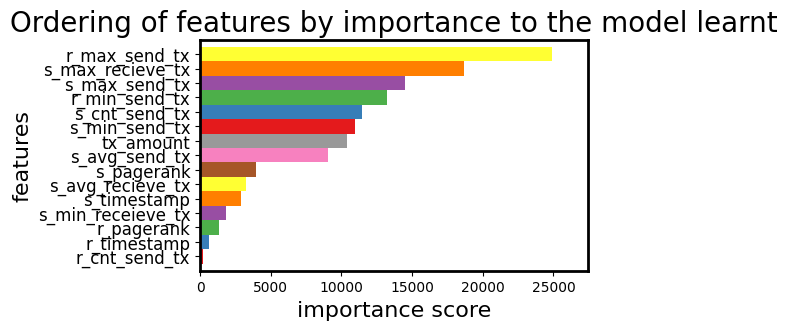

In [21]:
from xgboost import plot_importance, to_graphviz
fig = plt.figure(figsize = (5, 3))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(xgb_model, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

ax.set_xlabel('importance score', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance to the model learnt', size = 20);
to_graphviz(xgb_model)

In [18]:
from explainerdashboard import ClassifierExplainer, ExplainerDashboard
explainer = ClassifierExplainer(xgb_model, X_test, y_test)
ExplainerDashboard(explainer).run()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


Note: shap values for shap='kernel' normally get calculated against X_background, but paramater X_background=None, so setting X_background=shap.sample(X, 50)...
Generating self.shap_explainer = shap.KernelExplainer(model, X, link='identity')
Building ExplainerDashboard..
Detected google colab environment, setting mode='external'
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...


/usr/local/lib/python3.10/dist-packages/dash/dash.py:525: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



  0%|          | 0/93887 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Training the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)

# Fitting the model on the training set
knn_model.fit(X_train, y_train)

# Making predictions on the test set using KNN
knn_test_predictions = knn_model.predict(X_test)

# Evaluate the KNN model using Precision on the test set
knn_test_precision = precision_score(y_test, knn_test_predictions)
print(f"KNN Test precision: {knn_test_precision}")

# Making predictions on the validation set using KNN
knn_val_predictions = knn_model.predict(X_val)

# Evaluate the KNN model using Precision on the validation set
knn_val_precision = precision_score(y_val, knn_val_predictions)
print(f"KNN Validation precision: {knn_val_precision}")


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, f1_score
result = confusion_matrix(y_test, knn_test_predictions)
print("Confusion Matrix:")
print(result)
print('\n')
result1 = classification_report(y_test, knn_test_predictions)
print("Classification Report:",)
print (result1)
print('\n')
result2 = accuracy_score(y_test,knn_test_predictions)
print("Accuracy:",result2)
print('\n')
# calculate precision and recall scores
precision = precision_score(y_test, knn_test_predictions)
recall = recall_score(y_test, knn_test_predictions)
f1score = f1_score(y_test, knn_test_predictions)

# print the results
print("Precision:", precision)
print("Recall:", recall)
print("f1 score:", recall)

print(roc_auc_score(y_test, knn_test_predictions))

fpr, tpr, _ = roc_curve(y_test, knn_test_predictions)

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

In [ ]:
from explainerdashboard import ClassifierExplainer, ExplainerDashboard
explainer = ClassifierExplainer(knn_model, X_test, y_test)
ExplainerDashboard(explainer).run()

##Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(
    criterion='entropy', max_depth=5, min_samples_split=2,
    min_samples_leaf=1, random_state=42
)

# Training the Decision Tree model
dt_model.fit(X_train, y_train)

# Making predictions on the validation set using the Decision Tree model
dt_val_predictions = dt_model.predict(X_val)

# Evaluate the Decision Tree model using Precision on the validation set
dt_val_precision = precision_score(y_val, dt_val_predictions)
print(f"Decision Tree Validation precision: {dt_val_precision}")

# Making predictions on the test set using the Decision Tree model
dt_test_predictions = dt_model.predict(X_test)

# Evaluate the Decision Tree model using Precision on the test set
dt_test_precision = precision_score(y_test, dt_test_predictions)
print(f"Decision Tree Test precision: {dt_test_precision}")


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, f1_score
result = confusion_matrix(y_test, dt_test_predictions)
print("Confusion Matrix:")
print(result)
print('\n')
result1 = classification_report(y_test, dt_test_predictions)
print("Classification Report:",)
print (result1)
print('\n')
result2 = accuracy_score(y_test,dt_test_predictions)
print("Accuracy:",result2)
print('\n')
# calculate precision and recall scores
precision = precision_score(y_test, dt_test_predictions)
recall = recall_score(y_test, dt_test_predictions)
f1score = f1_score(y_test, dt_test_predictions)

# print the results
print("Precision:", precision)
print("Recall:", recall)
print("f1 score:", recall)

print(roc_auc_score(y_test, dt_test_predictions))

fpr, tpr, _ = roc_curve(y_test, dt_test_predictions)

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

## GNN


Model building

In [ ]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [ ]:
class GNNModel(torch.nn.Module):
    def __init__(self, num_node_features):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(num_node_features, 32)  # Increased from 16 to 32
        self.conv2 = GCNConv(32, 16)  # New layer
        self.conv3 = GCNConv(16, 2)  # Output layer

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)  # New layer
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)


Test train split

In [ ]:
from sklearn.model_selection import train_test_split

# Initial train-test split
train_fraud, temp_fraud = train_test_split(fraud_resampled_scaled, test_size=0.4, random_state=42, stratify=fraud_resampled_scaled['tx_fraud'])

# Split the remaining 40% into validation and test sets
val_fraud, test_fraud = train_test_split(temp_fraud, test_size=0.5, random_state=42, stratify=temp_fraud['tx_fraud'])

# Initialize masks
train_mask = torch.zeros(len(fraud_resampled_scaled), dtype=torch.bool)
val_mask = torch.zeros(len(fraud_resampled_scaled), dtype=torch.bool)
test_mask = torch.zeros(len(fraud_resampled_scaled), dtype=torch.bool)

# Update masks based on the indices of the train, validation and test sets
train_mask[train_fraud.index] = True
val_mask[val_fraud.index] = True
test_mask[test_fraud.index] = True

# Update your data object
data_scaled.train_mask = train_mask
data_scaled.val_mask = val_mask
data_scaled.test_mask = test_mask
data_scaled.y = torch.tensor(fraud_resampled_scaled['tx_fraud'].values, dtype=torch.long)

print("Graph constructed and train-validation-test split done.")


Training

In [ ]:
# Number of node features
num_node_features = x_scaled.shape[1]

In [ ]:
# Initialize the model and optimizer
model = GNNModel(data_scaled.num_node_features)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop with validation
for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data_scaled)

    # Training loss
    train_loss = F.nll_loss(out[data_scaled.train_mask], data_scaled.y[data_scaled.train_mask])
    train_loss.backward()
    optimizer.step()

    # Validation loss
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Deactivate autograd engine to reduce memory usage and speed up computations
        val_loss = F.nll_loss(out[data_scaled.val_mask], data_scaled.y[data_scaled.val_mask])

    print(f"Epoch {epoch+1}, Training Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}")

In [ ]:
# Testing and Evaluation
model.eval()
_, pred = out.max(dim=1)
correct = float(pred[data_scaled.test_mask].eq(data_scaled.y[data_scaled.test_mask]).sum().item())
acc = correct / data_scaled.test_mask.sum().item()
print(f"Test Accuracy: {acc}")

from sklearn.metrics import precision_score


# Testing and Evaluation
model.eval()
_, pred = out.max(dim=1)

# Extract ground truth and predictions for test set
true_labels = data_scaled.y[data_scaled.test_mask].cpu().numpy()
predicted_labels = pred[data_scaled.test_mask].cpu().numpy()

In [ ]:

result = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(result)
print('\n')
result1 = classification_report(true_labels, predicted_labels)
print("Classification Report:",)
print (result1)
print('\n')
result2 = accuracy_score(true_labels,predicted_labels)
print("Accuracy:",result2)
print('\n')
# calculate precision and recall scores
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1score = f1_score(true_labels, predicted_labels)

# print the results
print("Precision:", precision)
print("Recall:", recall)
print("f1 score:", recall)

print(roc_auc_score(true_labels, predicted_labels))

fpr, tpr, _ = roc_curve(true_labels, predicted_labels)

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()